# Autoencoder

In [14]:
import numpy 
import matplotlib.pyplot as plt
from tensorflow import keras 
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

## Daten Einlesen

In [15]:
# Insgesamt 10000
X_test_AE = numpy.loadtxt(open("mnist_test.csv", "rb"), delimiter=",", usecols=range(1,785), max_rows=5000)
Y_test_AE = numpy.loadtxt(open("mnist_test.csv", "rb"), delimiter=",", usecols=range(0,1), max_rows=5000)
X_test_SVM = numpy.loadtxt(open("mnist_test.csv", "rb"), delimiter=",", usecols=range(1,785), skiprows=5000)
Y_test_SVM = numpy.loadtxt(open("mnist_test.csv", "rb"), delimiter=",", usecols=range(0,1), skiprows=5000)
X_test_AE = X_test_AE.reshape(-1, 28, 28)
X_test_SVM = X_test_SVM.reshape(-1, 28, 28)

# Insgesamt 60000
X_train_AE = numpy.loadtxt(open("mnist_train.csv", "rb"), delimiter=",", usecols=range(1,785), max_rows=30000)
Y_train_AE = numpy.loadtxt(open("mnist_train.csv", "rb"), delimiter=",", usecols=range(0,1),max_rows=30000)
X_train_SVM = numpy.loadtxt(open("mnist_train.csv", "rb"), delimiter=",", usecols=range(1,785), skiprows=30000)
Y_train_SVM = numpy.loadtxt(open("mnist_train.csv", "rb"), delimiter=",", usecols=range(0,1), skiprows=30000)
X_train_AE = X_train_AE.reshape(-1, 28, 28)
X_train_SVM = X_train_SVM.reshape(-1, 28, 28)

In [16]:
# anpassen für Tensorflow
# AE
X_train_AE = X_train_AE.astype('float32') / 255.
X_test_AE=  X_test_AE.astype('float32') / 255.

# SVM
X_train_SVM = X_train_SVM.astype('float32') / 255.
X_test_SVM =  X_test_SVM.astype('float32') / 255.


## Autoencoder

In [17]:
latent_dim = 49 #64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)


In [18]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [19]:
autoencoder.fit(X_train_AE, X_train_AE,
                epochs=10,
                shuffle=True,
                validation_data=(X_test_AE, X_test_AE))


Epoch 1/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0380 - val_loss: 0.0206
Epoch 2/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0155 - val_loss: 0.0122
Epoch 3/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0099 - val_loss: 0.0088
Epoch 4/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0077 - val_loss: 0.0074
Epoch 5/10
938/938 [==============================] - 1s 2ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 6/10
938/938 [==============================] - 1s 2ms/step - loss: 0.0064 - val_loss: 0.0066
Epoch 7/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 8/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 9/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0060 - val_loss: 0.0063
Epoch 10/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0059 - val_loss: 0.0062

In [20]:
autoencoder.summary()

Model: "autoencoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    multiple                  38465     
_________________________________________________________________
sequential_3 (Sequential)    multiple                  39200     
Total params: 77,665
Trainable params: 77,665
Non-trainable params: 0
_________________________________________________________________


In [21]:
encoded_imgs = autoencoder.encoder(X_test_AE).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()


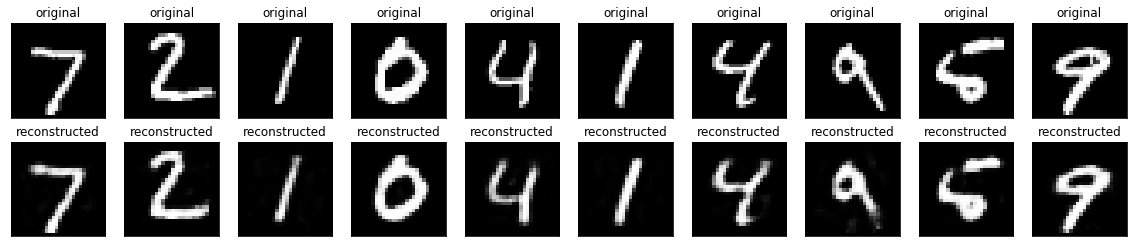

In [22]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test_AE[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


## SVM

In [23]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [24]:
# Encoder für das reduzieren der Dimensionen.

X_train = autoencoder.encoder(X_train_SVM).numpy()
X_test = autoencoder.encoder(X_test_SVM).numpy()
y_train = Y_train_SVM
y_test = Y_test_SVM

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)


(30000, 49)
(5000, 49)
(30000,)
(5000,)


In [25]:
svm = SVC(kernel='linear', probability=True, random_state=42)       # SVM Definition
svm.fit(X_train, y_train)                                           # Modell Trainieren

SVC(kernel='linear', probability=True, random_state=42)

In [26]:
y_pred = svm.predict(X_test)                     # Prediction für den Test Datensatz
accuracy = accuracy_score(y_test, y_pred)        # Auswertung
print('Model accuracy: ', accuracy)              # Ausgabe der Genauigkeit

Model accuracy:  0.9564
